## Pipeline to search best model

In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

## Final Model

### Pipeline 3.1 : tous les modèles avec paramètres par défaut 

In [19]:
# Initialize the classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = RandomForestClassifier(random_state=42)
clf4 = SVC(random_state=42, probability=True)
clf5 = KNeighborsClassifier()

# Initialize the hyperparameters for each dictionary
param1 = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'clf__penalty': ['l2'], 'clf': [clf1]}
param2 = {'clf__max_depth': [None, 5, 10, 15, 20], 'clf__min_samples_split': [2, 5, 10], 'clf': [clf2]}
param3 = {'clf__n_estimators': [10, 50, 100, 200], 'clf__max_depth': [None, 5, 10, 15, 20], 'clf': [clf3]}
param4 = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'clf__gamma': ['scale', 'auto'], 'clf': [clf4]}
param5 = {'clf__n_neighbors': [3, 5, 7, 9, 11], 'clf': [clf5]}

## rajouter ici les preprocessing

# Create a pipeline
pipeline = Pipeline([('clf', clf1)])
params = [param1, param2, param3, param4, param5]

#Demander de calculer d'autres métrics sur le valide set
scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Use RandomizedSearchCV to find the best parameters
gs = RandomizedSearchCV(pipeline, params, n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring=scorings,refit='roc_auc', return_train_score=True)

start = time.time()

# Fit the model
gs.fit(X_train, y_train)

print("Execution time: " + str((time.time() - start)) + ' ms')
print()
print("Best parameters: ", gs.best_params_)
print()
print("Best training AUC: ", gs.best_score_)
print()
# Predict the labels of the test set
y_pred = gs.predict(X_test)

# Calculate the probabilities for the test set
y_pred_proba = gs.predict_proba(X_test)[:, 1]

# Compute the AUC score, precision, recall, and F1 score
auc_test = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [gs.best_params_['clf'].__class__.__name__],
    'Best Parameters': [gs.best_params_],
    'Training AUC': [gs.best_score_],
    'Test AUC': [auc_test],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Execution time: 352.74126839637756 ms

Best parameters:  {'clf__n_estimators': 100, 'clf__max_depth': 20, 'clf': RandomForestClassifier(max_depth=20, random_state=42)}

Best training AUC:  0.6817312086060937

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'clf__n_estimators': 100, 'clf__max_depth': 2...   

   Training AUC  Test AUC  Precision  Recall  F1 Score  
0      0.681731  0.642857        0.0     0.0       0.0  


c:\Users\dalila.derdar.ONCEFORALL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
cm_1 = confusion_matrix(y_test, y_pred)
cm_1

array([[793,   0],
       [ 70,   0]], dtype=int64)

In [20]:
results 

,Model,Best Parameters,Training AUC,Test AUC,Precision,Recall,F1 Score
0,RandomForestClassifier,"{'clf__n_estimators': 100, 'clf__max_depth': 2...",0.681731,0.642857,0.0,0.0,0.0


### Pipeline 3.2 : recherche des meilleurs hyerparamètres sur le meilleur modèle randomforest

#### Pipeline 3-2-1 recherche des meilleurs hyerparamètres sur le meilleur modèle randomforest - score roc_auc

In [8]:
#Réentrainer avec plus d'hyperparamètres de Random Forest

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

scorings = ['roc_auc', 'precision', 'recall', 'f1']
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring= scorings, refit= 'roc_auc')

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

# Predict the labels of the test set
y_pred = random_search.predict(X_test)

# Evaluate on the test set
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [random_search.best_estimator_.__class__.__name__],
    'Best Parameters': [random_search.best_params_],
    'Training AUC': [random_search.best_score_],
    'Test AUC': [auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Best parameters:  {'class_weight': 'balanced', 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 155}
                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': 'balanced', 'max_depth': 14, ...   

   Training AUC  Test AUC  Precision    Recall  F1 Score  
0      0.710788  0.685246   0.333333  0.071429  0.117647  


In [9]:
#afficher la matrice de confusion pour le meilleur modèle
#matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[783  10]
 [ 65   5]]


#### Pipeline 3-2-2 recherche des meilleurs hyerparamètres sur le meilleur modèle randomforest - score recall

In [6]:
#Réentrainer avec plus d'hyperparamètres de Random Forest

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

scorings = ['roc_auc', 'precision', 'recall', 'f1']
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring= scorings, refit= 'recall')

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

# Predict the labels of the test set
y_pred = random_search.predict(X_test)

# Evaluate on the test set
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [random_search.best_estimator_.__class__.__name__],
    'Best Parameters': [random_search.best_params_],
    'Training AUC': [random_search.best_score_],
    'Test AUC': [auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Best parameters:  {'class_weight': 'balanced', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 195}
                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': 'balanced', 'max_depth': 2, '...   

   Training AUC  Test AUC  Precision    Recall  F1 Score  
0      0.572338  0.696379   0.131429  0.657143  0.219048  


In [7]:
#afficher la matrice de confusion pour le meilleur modèle
#matrice de confusion
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[489 304]
 [ 24  46]]


### Pipeline 3-3 modification des hyperparamètres du meilleur modèle randomforest

In [16]:
#Réentrainer avec changement de seuil de décision à 0.3

# Define the hyperparameters
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", random_search.best_params_)

# Predict the labels of the test set with a different threshold
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)

# Evaluate on the test set
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Store the results in a DataFrame
results = pd.DataFrame({
    'Model': [random_search.best_estimator_.__class__.__name__],
    'Best Parameters': [random_search.best_params_],
    'Training AUC': [random_search.best_score_],##ce n'est pas le score train score mais le score de validation. Plutôt faire y_train_pred = random_search.predict(X_train) 
    'Test AUC': [auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
})

print(results)


Best parameters:  {'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 9, 'n_estimators': 148}
                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': None, 'max_depth': 10, 'max_f...   

   Training AUC  Test AUC  Precision    Recall  F1 Score  
0      0.919758   0.71207     0.3125  0.071429  0.116279  


Le score d'AUC pour le jeu d'entraînement est de 0.92, ce qui indique que le modèle est capable de distinguer efficacement les remboursements des non-remboursements sur le jeu de données d'entraînement. Cependant, le score d'AUC pour le jeu de test est de 0.71, ce qui est significativement plus bas. Cela peut indiquer que le modèle surapprend sur le jeu de données d'entraînement (overfitting) et ne généralise pas bien aux nouvelles données.

La précision est de 0.31, ce qui signifie que seulement 31% des prêts que le modèle prédit comme étant en défaut (1 = ne peut pas rembourser) sont effectivement en défaut. En d'autres termes, beaucoup de prêts qui auraient pu être remboursés sont refusés par le modèle.

Le recall est de 0.071, ce qui signifie que le modèle est seulement capable de détecter environ 7.1% des défauts de remboursement. En d'autres termes, le modèle laisse passer environ 93% des défauts de remboursement, ce qui est très problématique car cela signifie que beaucoup de prêts qui ne seront pas remboursés sont accordés.

Le score F1 est une moyenne harmonique de la précision et du rappel, et il est généralement plus utile que la précision lorsque vous avez une répartition inégale des classes (c'est-à-dire beaucoup plus de remboursements que de défauts de remboursement). Un score F1 de 0.116 est assez faible, ce qui indique que le modèle ne parvient pas à trouver un bon équilibre entre précision et rappel.

ces résultats suggèrent que votre modèle a du mal à identifier les défauts de remboursement, et il est probablement trop prudent en refusant beaucoup de prêts qui seraient effectivement remboursés. Cela pourrait être dû à une sous-représentation des défauts de remboursement dans les données, ou à un seuil de décision qui est trop élevé.

Essayer le rééquilibrage des classes

### Pipeline 3-4 Randomforest et test hyperparamètres - intégration preprocessing + ML FLow

In [14]:
# Lire les données
sample_df = pd.read_csv('../data/sample_df.csv')

# Remplacer les valeurs infinies par des NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Séparer la cible du reste des données
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']
print(f"shape de X : {X.shape}")
print(f"shape de y : {y.shape}")

# Construire le pipeline de prétraitement
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])

# Application du prétraitement et split du dataset
X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###Setup MLFLOW
mlflow.set_experiment('Scoring_models')
mlflow.sklearn.autolog()

# Définir les hyperparamètres
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'class_weight': ['balanced', None],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Initialiser le classifieur
clf = RandomForestClassifier(random_state=42)

scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Initialiser RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=scorings, refit='recall')

# Start an MLflow run
with mlflow.start_run(run_name='test_1'):

    # Entraîner le modèle
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Calculate train score
    train_score = recall_score(y_train, best_model.predict(X_train))

    # Calculate validation score (best_score_ is already based on validation set because we're using cross-validation in RandomizedSearchCV)
    validation_score = random_search.best_score_

    # Prédire les labels de l'ensemble de test
    y_pred = random_search.predict(X_test)

    # Evaluate on the test set
    test_score = recall_score(y_test, y_pred)

    # Evaluer sur l'ensemble de test
    y_pred_proba = random_search.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log the parameters
    mlflow.log_params(random_search.best_params_)


    # Log the metrics
    mlflow.log_metric("Training Recall", train_score)
    mlflow.log_metric("Validation Recall", validation_score)
    mlflow.log_metric("Test Recall", test_score)
    mlflow.log_metric("Test AUC", auc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)

    # Log the model
    mlflow.sklearn.log_model(best_model, "model")
    # Stocker les résultats dans un DataFrame
    results = pd.DataFrame({
        'Model': [best_model.__class__.__name__],
        'Best Parameters': [random_search.best_params_],
        'Training AUC': [random_search.best_score_],
        'Test AUC': [auc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1], 
        'Training Recall': [train_score],
        'Validation Recall': [validation_score],
        'Test Recall': [test_score]
    })

print(results)


2023/07/10 16:51:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a6d4f388e5094b62938ca6fffa1838ec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


shape de X : (4315, 797)
shape de y : (4315,)


2023/07/10 16:51:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DalilaDerdar\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/07/10 16:51:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were no

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'class_weight': 'balanced', 'max_depth': 2, '...   

   Training AUC  Test AUC  Precision    Recall  F1 Score  Training Recall  \
0      0.417208  0.657737   0.153846  0.485714  0.233677         0.640288   

   Validation Recall  Test Recall  
0           0.417208     0.485714  


### Pipeline 3-5 Randomforest, test hyperparamètres - pipeline preprocessing & classifier + ML FLow on recall

In [28]:
# Read data
sample_df = pd.read_csv('../data/sample_df.csv')

# Replace infinite values with NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate the target from the rest of the data
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Setup MLFLOW
mlflow.set_experiment('Scoring_models')
mlflow.sklearn.autolog()

# Define preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])

# Define classifier
clf = RandomForestClassifier(random_state=42)

# Combine preprocessing and classifier into a single pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Define hyperparameters for the Random Forest Classifier
param_dist = {
    'classifier__n_estimators': randint(100, 200),
    'classifier__max_depth': randint(1,5),
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
    'classifier__min_samples_split': randint(20,40),
    'classifier__min_samples_leaf': randint(10,40),
    'classifier__max_features': ['sqrt', 'log2', None]
}

scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5,n_jobs=-1, scoring=scorings, refit='recall', n_iter=25, random_state=42)

# Start an MLflow run
with mlflow.start_run(run_name='Modelisation_recall_1'):

    # Train the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Calculate train score
    train_score = recall_score(y_train, best_model.predict(X_train))

    # Calculate validation score
    validation_score = random_search.best_score_

    # Predict the labels of the test set
    y_pred = random_search.predict(X_test)

    # Evaluate on the test set
    test_score = recall_score(y_test, y_pred)

    # Evaluate on the test set
    y_pred_proba = random_search.predict_proba(X_test)[:, 1]
    threshold = 0.4
    y_pred = (y_pred_proba > threshold).astype(int)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log the parameters
    mlflow.log_params(random_search.best_params_)

    # Log the metrics
    mlflow.log_metric("Training Recall", train_score)
    mlflow.log_metric("Validation Recall", validation_score)
    mlflow.log_metric("Test Recall", test_score)
    mlflow.log_metric("Test AUC", auc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)

    # Log the model
    mlflow.sklearn.log_model(best_model, "model")

    # Store the results in a DataFrame
    results = pd.DataFrame({
        'Model': [random_search.best_estimator_.named_steps['classifier'].__class__.__name__],
        'Best Parameters': [random_search.best_params_],
        'Training Recall': [train_score],
        'Validation Recall': [validation_score],
        'Test Recall': [test_score],
        'Test AUC': [auc],
        'Precision': [precision],
        'F1 Score': [f1] 
    })

print(results)


2023/07/18 17:03:49 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/07/18 17:03:50 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002006228F5E0>, 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000200622ADAE0>, 'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000200622AD450>, 'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen objec...`
2023/07/18 17:03:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DalilaDerdar\AppData\Local\Program

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'classifier__class_weight': 'balanced_subsamp...   

   Training Recall  Validation Recall  Test Recall  Test AUC  Precision  \
0         0.676259           0.594156     0.671429  0.667006   0.097372   

   F1 Score  
0  0.175732  


In [29]:
cm_recall = confusion_matrix(y_test, y_pred)
print(cm_recall)

[[209 584]
 [  7  63]]


### Pipeline 3-6 Randomforest, test hyperparamètres - pipeline preprocessing & classifier + ML FLow - score roc_auc

In [32]:
# Read data
sample_df = pd.read_csv('../data/sample_df.csv')

# Replace infinite values with NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate the target from the rest of the data
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Setup MLFLOW
mlflow.set_experiment('Scoring_models')
mlflow.sklearn.autolog()

# Define preprocessing pipeline
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])

# Define classifier
clf = RandomForestClassifier(random_state=42)

# Combine preprocessing and classifier into a single pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# Define hyperparameters for the Random Forest Classifier
param_dist = {
    'classifier__n_estimators': randint(150, 500),
    'classifier__max_depth': randint(1,10),
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
    'classifier__min_samples_split': randint(20,40),
    'classifier__min_samples_leaf': randint(20,40),
    'classifier__max_features': ['sqrt', 'log2', None]
}

scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=scorings, refit='roc_auc', n_iter=35, random_state=42)

# Start an MLflow run
with mlflow.start_run(run_name='Modelisation_auc_5'):

    # Train the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Predict the labels of the test set
    y_pred = best_model.predict(X_test)

    # Calculate training metrics
    train_pred_proba = best_model.predict_proba(X_train)[:, 1]
    train_pred = best_model.predict(X_train)
    training_auc = roc_auc_score(y_train, train_pred_proba)
    training_precision = precision_score(y_train, train_pred)
    training_recall = recall_score(y_train, train_pred)
    training_f1 = f1_score(y_train, train_pred)

    # Calculate validation metrics
    validation_auc = random_search.best_score_

    # Calculate test metrics
    test_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log the parameters
    mlflow.log_params(random_search.best_params_)

    # Log the metrics
    mlflow.log_metric("Training AUC", training_auc)
    mlflow.log_metric("Validation AUC", validation_auc)
    mlflow.log_metric("Test AUC", test_auc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)

    # Log the model
    mlflow.sklearn.log_model(best_model, "model")

    # Store the results in a DataFrame
    results = pd.DataFrame({
        'Model': [random_search.best_estimator_.named_steps['classifier'].__class__.__name__],
        'Best Parameters': [random_search.best_params_],
        'Training AUC': [training_auc],
        'Validation AUC': [validation_auc],
        'Test AUC': [test_auc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

print(results)


2023/07/18 17:28:39 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/07/18 17:28:39 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002005DD6E3E0>, 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002005D651BD0>, 'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002005D652F20>, 'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen objec...`
2023/07/18 17:28:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DalilaDerdar\AppData\Local\Program

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'classifier__class_weight': 'balanced_subsamp...   

   Training AUC  Validation AUC  Test AUC  Precision    Recall  F1 Score  
0      0.984054        0.714826  0.704468    0.26087  0.257143  0.258993  


In [33]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[742  51]
 [ 52  18]]


### Pipeline 3-7 - Randomforest, test hyperparamètres - pipeline preprocessing & classifier + ML FLow + SMOTE

In [34]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE


# Read data
sample_df = pd.read_csv('../data/sample_df.csv')

# Replace infinite values with NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate the target from the rest of the data
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Setup MLFLOW
mlflow.set_experiment('Scoring_models')
mlflow.sklearn.autolog()

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Define classifier
clf = RandomForestClassifier(random_state=42)

# Combine preprocessing, SMOTE, and classifier into a single pipeline because we use imbleanr library (can't use pipeline on pipeline)
pipeline = imbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler()),
    ('smote', smote),
    ('classifier', clf)
])

# Define hyperparameters for the Random Forest Classifier
param_dist = {
    'classifier__n_estimators': randint(100, 200),
    'classifier__max_depth': randint(1, 5),
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
    'classifier__min_samples_split': randint(20, 40),
    'classifier__min_samples_leaf': randint(10, 40),
    'classifier__max_features': ['sqrt', 'log2', None]
}

scorings = ['roc_auc', 'precision', 'recall', 'f1']

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=scorings, refit='roc_auc', n_iter=35)

# Start an MLflow run
with mlflow.start_run(run_name='Modelisation_auc_smote_1'):

    # Train the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Calculate train score
    train_score = roc_auc_score(y_train, best_model.predict(X_train))

    # Calculate validation score
    validation_score = random_search.best_score_

    # Predict the labels of the test set
    y_pred = random_search.predict(X_test)

    # Evaluate on the test set
    test_score = roc_auc_score(y_test, y_pred)

    # Evaluate on the test set
    y_pred_proba = random_search.predict_proba(X_test)[:, 1]
    threshold = 0.4
    y_pred = (y_pred_proba > threshold).astype(int)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log the parameters
    mlflow.log_params(random_search.best_params_)

    # Log the metrics
    mlflow.log_metric("Training ROC AUC", train_score)
    mlflow.log_metric("Validation ROC AUC", validation_score)
    mlflow.log_metric("Test ROC AUC", test_score)
    mlflow.log_metric("Test AUC", auc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1)

    # Log the model
    mlflow.sklearn.log_model(best_model, "model")

    # Store the results in a DataFrame
    results = pd.DataFrame({
        'Model': [random_search.best_estimator_.named_steps['classifier'].__class__.__name__],
        'Best Parameters': [random_search.best_params_],
        'Training ROC AUC': [train_score],
        'Validation ROC AUC': [validation_score],
        'Test ROC AUC': [test_score],
        'Test AUC': [auc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

print(results)



2023/07/18 17:56:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/07/18 17:56:18 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000200623555D0>, 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002005FA78820>, 'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002005FA7A380>, 'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen objec...`
2023/07/18 17:56:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DalilaDerdar\AppData\Local\Program

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'classifier__class_weight': 'balanced', 'clas...   

   Training ROC AUC  Validation ROC AUC  Test ROC AUC  Test AUC  Precision  \
0          0.640933            0.668002       0.58675  0.670924   0.136076   

     Recall  F1 Score  
0  0.614286  0.222798  


In [35]:
cm_smote = confusion_matrix(y_test, y_pred)
print(cm_smote)

[[520 273]
 [ 27  43]]


### Pipeline 3-8 - Randomforest, test hyperparamètres - pipeline preprocessing & classifier + ML FLow + SMOTE - métric métier

In [4]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, confusion_matrix

# Custom metric
def custom_cost_only_fn(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    Profit_bycustomer = (1*tn - 10*fn) / y_true.shape[0]
    return Profit_bycustomer

custom_scorer_fn_only = make_scorer(custom_cost_only_fn, greater_is_better=True)

# Read data
sample_df = pd.read_csv('../data/sample_df.csv')

# Replace infinite values with NaN
sample_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Separate the target from the rest of the data
X = sample_df.drop(columns=["TARGET"])
y = sample_df['TARGET']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Setup MLFLOW
mlflow.set_experiment('Scoring_models')
mlflow.sklearn.autolog()

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Define classifier
clf = RandomForestClassifier(random_state=42)

# Combine preprocessing, SMOTE, and classifier into a single pipeline
pipeline = imbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler()),
    ('smote', smote),
    ('classifier', clf)
])

# Define hyperparameters for the Random Forest Classifier
param_dist = {
    'classifier__n_estimators': randint(100, 200),
    'classifier__max_depth': randint(1, 5),
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
    'classifier__min_samples_split': randint(20, 40),
    'classifier__min_samples_leaf': randint(10, 40),
    'classifier__max_features': ['sqrt', 'log2', None]
}

# Add your custom scorer to the list of scorings
scorings = {
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'custom_score': custom_scorer_fn_only
}

# Initialize RandomizedSearchCV with your custom scorer
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, cv=5, n_jobs=-1, scoring=scorings, refit='roc_auc', n_iter=35, random_state=42)

# Start an MLflow run
with mlflow.start_run(run_name='Modelisation_custom_metric_10'):

    # Train the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_model = random_search.best_estimator_

    # Serialisation du meilleur modèle
    import joblib
    joblib.dump(best_model, 'best_model.pkl')
    joblib.dump(X, 'X.pkl')
    joblib.dump(X_test, 'X_test.pkl')


    # Calculate train score
    train_score = roc_auc_score(y_train, best_model.predict(X_train))

    # Calculate validation score
    validation_score = random_search.best_score_

    # Predict the labels of the test set
    y_pred = random_search.predict(X_test)

    # Evaluate on the test set
    test_score = roc_auc_score(y_test, y_pred)

    # Calculate custom metric
    test_custom_cost = custom_cost_only_fn(y_test, y_pred)

    # Calculate custom metric for the training set
    train_custom_cost = custom_cost_only_fn(y_train, best_model.predict(X_train))

    # Predict the probabilities of the test set
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    threshold = 0.37 #par défaut, fixé à 0.5
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate other metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log the parameters
    mlflow.log_params(random_search.best_params_)

    # Log the metrics
    mlflow.log_metric("Training ROC AUC", train_score)
    mlflow.log_metric("Validation ROC AUC", validation_score)
    mlflow.log_metric("Test ROC AUC", test_score)
    mlflow.log_metric("Test AUC", auc)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall) 
    mlflow.log_metric("F1 Score", f1)
    mlflow.log_metric("Training Custom Metric", train_custom_cost)
    mlflow.log_metric("Test Custom Metric", test_custom_cost)

    # Log the model
    mlflow.sklearn.log_model(best_model, "model")

    # Store the results in a DataFrame
    results = pd.DataFrame({
        'Model': [random_search.best_estimator_.named_steps['classifier'].__class__.__name__],
        'Best Parameters': [random_search.best_params_],
        'Training ROC AUC': [train_score],
        'Validation ROC AUC': [validation_score],
        'Test ROC AUC': [test_score],
        'Test AUC': [auc],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'Training Custom Metric': [train_custom_cost],
        'Test Custom Metric': [test_custom_cost]
    })

print(results)


2023/09/06 15:17:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/09/06 15:17:54 WARNING mlflow.utils: Truncated the value of the key `param_distributions`. Truncated value: `{'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EE71AFD90>, 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EEAE64460>, 'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023EEAE651B0>, 'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen objec...`
2023/09/06 15:17:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\DalilaDerdar\AppData\Local\Program

                    Model                                    Best Parameters  \
0  RandomForestClassifier  {'classifier__class_weight': 'balanced', 'clas...   

   Training ROC AUC  Validation ROC AUC  Test ROC AUC  Test AUC  Precision  \
0          0.640709            0.668984      0.590533  0.670366   0.118227   

     Recall  F1 Score  Training Custom Metric  Test Custom Metric  
0  0.685714  0.201681                0.334299            0.247972  


In [5]:
cm_smote_metier = confusion_matrix(y_test, y_pred)
print(cm_smote_metier)

[[435 358]
 [ 22  48]]


#### Comparaison des résultats du custom metric

##### Custom metric pour un modèle parfait 

Profit_bycustomer = (1*tn - 10*fn) / y_true.shape[0]

Sur  base de cette CM 

[[522 271]

 [ 27  43]]


CM Parfaite (90% qui rembourse bien leur crédit - (tn) et 10% qui ne rembourse pas leur crédit (tp)

[[777 (TN), 0 (FN)],

[0 (FP), 86 (TP)]]

Calcul de la métrique métier

Profit_bycustomer = (1*793 - 10*0) / 863

Profit_bycustomer = 0.90

##### Custom metric pour un modèle naif

CM Naive (90% qui rembourse bien leur crédit - (TN) et 10% de faux négatif (FN)).

[[777 (TN), 86 (FN)],
[0 (FP), 0 (TP)]]

Calcul de la métrique métier

Profit_bycustomer = (1*777 - 10*86) / 863
Profit_bycustomer = -0,096


### Pipeline 3-9 - DummyClassifier, ML FLow + SMOTE - métric métier

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
import mlflow

# Initialize Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

# Pipeline for Dummy Classifier
dummy_pipeline = imbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler()),
    ('smote', smote),
    ('classifier', dummy_clf)
])

# Start an MLflow run
with mlflow.start_run(run_name='Dummy_model'):

    # Train the model
    dummy_pipeline.fit(X_train, y_train)

    # Predict the labels of the train set
    y_train_pred_dummy = dummy_pipeline.predict(X_train)

    # Calculate train score
    train_score_dummy = roc_auc_score(y_train, y_train_pred_dummy)

    # Predict the labels of the test set
    y_test_pred_dummy = dummy_pipeline.predict(X_test)

    # Evaluate on the test set
    test_score_dummy = roc_auc_score(y_test, y_test_pred_dummy)

    # Log the metrics
    mlflow.log_metric("Training ROC AUC", train_score_dummy)
    mlflow.log_metric("Test ROC AUC", test_score_dummy)

    # Log the model
    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

    # Store the results in a DataFrame
    dummy_results = pd.DataFrame({
        'Model': ['DummyClassifier'],
        'Training ROC AUC': [train_score_dummy],
        'Test ROC AUC': [test_score_dummy]
    })

print(dummy_results)


2023/07/26 12:48:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/07/26 12:48:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/07/26 12:48:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/07/26 12:48:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


             Model  Training ROC AUC  Test ROC AUC
0  DummyClassifier          0.491572      0.472374


## Importances des features globales

In [7]:
# Obtenir les importances des caractéristiques du modèle
importances = best_model.named_steps['classifier'].feature_importances_

# Créer un DataFrame pour visualiser les importances des caractéristiques
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Trier le DataFrame en fonction des importances
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Afficher les importances
print(feature_importances)


                                     Feature  Importance
33                              EXT_SOURCE_2    0.039478
3                               FLAG_OWN_CAR    0.037136
125                 NAME_INCOME_TYPE_Working    0.030337
529          PREV_NAME_YIELD_GROUP_high_MEAN    0.029754
127     NAME_EDUCATION_TYPE_Higher education    0.026692
..                                       ...         ...
480  PREV_NAME_GOODS_CATEGORY_Gardening_MEAN    0.000000
479  PREV_NAME_GOODS_CATEGORY_Furniture_MEAN    0.000000
478    PREV_NAME_GOODS_CATEGORY_Fitness_MEAN    0.000000
477  PREV_NAME_GOODS_CATEGORY_Education_MEAN    0.000000
551        PREV_PRODUCT_COMBINATION_nan_MEAN    0.000000

[797 rows x 2 columns]


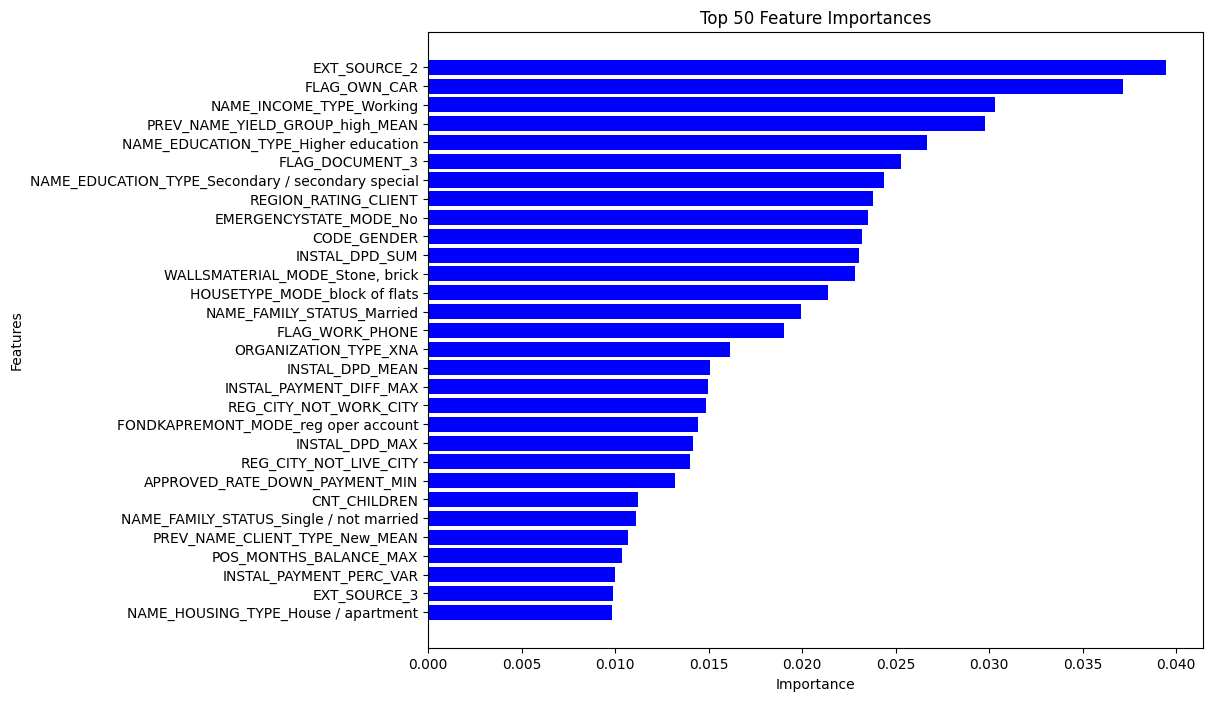

In [11]:
# Limiter le DataFrame aux 100 caractéristiques les plus importantes
top_30_features = feature_importances[:30]

# Créer un diagramme à barres pour les importances des caractéristiques
plt.figure(figsize=(10,8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], color='b', align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # Inverser l'axe y pour afficher la caractéristique la plus importante en haut
plt.show()


## Importance des features locales 

In [6]:
# Importer la bibliothèque SHAP
import shap

# Initialiser le "Tree Explainer" de SHAP
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])

# Calculer les valeurs SHAP pour les features de votre ensemble de test
shap_values = explainer.shap_values(X_test)

import joblib
joblib.dump(explainer, 'explainer.pkl')

# Visualiser les valeurs SHAP pour la première prédiction
shap.initjs()

# Afficher le graphique
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


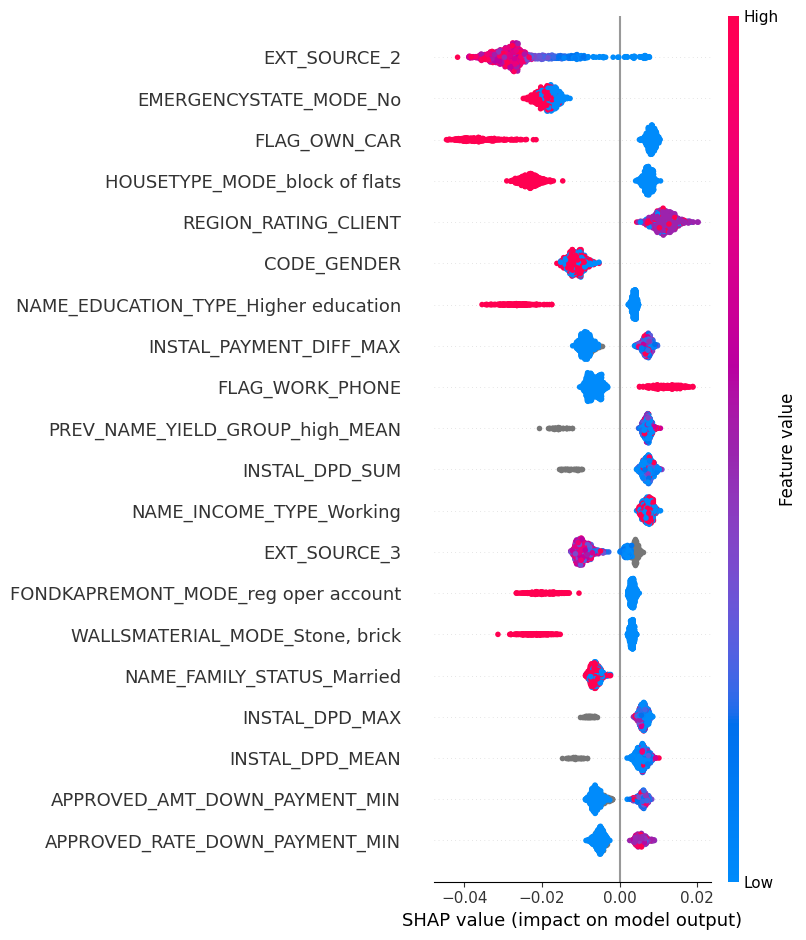

In [7]:
# Créer un graphique d'importance des features pour l'ensemble du test
shap.summary_plot(shap_values[1], X_test)

## Test Data drift

In [6]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

reference_data = pd.read_csv("../data/application_train.csv").drop(columns = ["TARGET"]).sample(10000)
current_data = pd.read_csv("../data/application_test.csv").sample(10000)

data_drift_report = Report(metrics=[DataDriftPreset()])

data_drift_report.run(current_data=current_data, reference_data=reference_data, column_mapping=None)
data_drift_report.save_html("data_drift.html")